In [1]:
import h5py

def print_hdf5_structure(file_path, max_level=None):
    """
    Recursively print the structure of an HDF5 file.

    Parameters
    ----------
    file_path : str
        Path to the HDF5 file.
    max_level : int or None
        If set, limits the depth of traversal (0 = root only).
    """
    def _print(name, obj, level=0):
        indent = "  " * level
        if isinstance(obj, h5py.Group):
            print(f"{indent}Group: {name}")
            for k, v in obj.attrs.items():
                print(f"{indent}    Attr: {k} = {v}")
        elif isinstance(obj, h5py.Dataset):
            print(f"{indent}Dataset: {name} (Shape: {obj.shape}, Dtype: {obj.dtype})")
        if max_level is None or level < max_level:
            if isinstance(obj, h5py.Group):
                for key in obj:
                    _print(f"{name}/{key}", obj[key], level+1)

    with h5py.File(file_path, "r") as f:
        _print("/", f)

# Example usage:
file_glob = "/pscratch/sd/k/kevinsg/bes_ml_jobs/exp_gill01/42448900/predictions_0.hdf5"  

print_hdf5_structure(file_glob, max_level=3)  # limit depth if file is huge


Group: /
  Group: //145385
    Group: //145385/segment_1057ms
        Attr: dt_ms = 1.0
        Attr: start_time_ms = 1057
      Dataset: //145385/segment_1057ms/logits (Shape: (109720, 3), Dtype: float32)
      Dataset: //145385/segment_1057ms/pred_classes (Shape: (109720,), Dtype: int64)
      Dataset: //145385/segment_1057ms/probs (Shape: (109720, 3), Dtype: float32)
      Dataset: //145385/segment_1057ms/times_ms (Shape: (109720,), Dtype: float32)
      Dataset: //145385/segment_1057ms/true_labels (Shape: (109720,), Dtype: int64)
    Group: //145385/segment_1496ms
        Attr: dt_ms = 1.0
        Attr: start_time_ms = 1496
      Dataset: //145385/segment_1496ms/logits (Shape: (244970, 3), Dtype: float32)
      Dataset: //145385/segment_1496ms/pred_classes (Shape: (244970,), Dtype: int64)
      Dataset: //145385/segment_1496ms/probs (Shape: (244970, 3), Dtype: float32)
      Dataset: //145385/segment_1496ms/times_ms (Shape: (244970,), Dtype: float32)
      Dataset: //145385/segment

In [2]:
import matplotlib as mpl
import os 

# 1. Get the current PATH environment variable
path_env = os.environ.get('PATH', '')
# 2. The directory path you found using 'which latex'
tex_path = '/global/common/software/nersc9/texlive/2024/bin/x86_64-linux'
# 3. Prepend your TeX path to the system PATH for this kernel
#    This ensures Matplotlib finds the 'latex' executable.
os.environ['PATH'] = f"{tex_path}:{path_env}"
# 1) Matplotlib settings
mpl.rcParams.update({
    'figure.dpi': 400,
    'figure.figsize': (7, 3),
    "text.usetex": True, # This will now work
    "font.family": "serif",
    "text.latex.preamble": r"""
        \usepackage{amsmath}
        \usepackage{amssymb}
        """,
    # 'mathtext.fontset': 'dejavuserif', # This setting is ignored when text.usetex=True
    'font.size': 12,
    'lines.linewidth': 0, # Note: this seems unusual, are you sure you want no line width?
    'legend.edgecolor': 'none',
    'axes.facecolor': 'w',
    'axes.edgecolor': 'k',
    'axes.labelcolor': 'k',
    'xtick.color': 'k',
    'ytick.color': 'k',
    'savefig.facecolor': 'w'
})


In [3]:
#!/usr/bin/env python3
from __future__ import annotations
import argparse, re
from dataclasses import dataclass
from typing import List, Optional, Sequence, Tuple

import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import AutoMinorLocator


@dataclass
class SegmentData:
    start_ms: float
    times_ms: np.ndarray  # (N_ds,)
    pred: np.ndarray      # (N_ds,)
    true: np.ndarray      # (N_ds,)
    probs: Optional[np.ndarray] = None  # (N_ds, K) or None


def _infer_n_classes(seg_grp: h5py.Group) -> int:
    for key in ("logits", "probs"):
        if key in seg_grp and seg_grp[key].ndim == 2:
            return int(seg_grp[key].shape[1])
    vals = []
    for key in ("pred_classes", "true_labels"):
        if key in seg_grp:
            a = np.asarray(seg_grp[key])
            if a.size:
                vals.append(int(a.max()))
    if vals:
        return max(vals) + 1
    raise ValueError("Could not infer number of classes; missing logits/probs and empty pred/true.")


def _downsample_indices(n: int, step: int) -> np.ndarray:
    idx = np.arange(0, n, step, dtype=int)
    if idx[-1] != n - 1:
        idx = np.append(idx, n - 1)
    return idx


def _downsample_categorical(arr: np.ndarray, step: int, n_classes: Optional[int] = None, unknown_value: int = -1):
    """Majority vote per non-overlapping block of length `step`.
    Ignores negative labels (e.g., -1). If a block has no non-negative labels,
    emits `unknown_value`. Returns (arr_ds, idx_centers)."""
    n = arr.size
    edges = list(range(0, n, step))
    if edges[-1] != n:
        edges.append(n)
    out, centers = [], []
    for b0, b1 in zip(edges[:-1], edges[1:]):
        block = arr[b0:b1]
        block_nonneg = block[block >= 0]
        if block_nonneg.size == 0:
            out.append(unknown_value)
        else:
            counts = (np.bincount(block_nonneg, minlength=n_classes)
                      if n_classes is not None else np.bincount(block_nonneg))
            out.append(int(counts.argmax()))
        centers.append((b0 + b1 - 1) // 2)
    return np.asarray(out, int), np.asarray(centers, int)


def _collect_segments(
    f: h5py.File,
    shot: str,
    fs_hz: float = 250_000.0,
    target_downsample_ms: float = 1.0,
    agg: str = "mode",   # "mode" (recommended) or "slice"
) -> Tuple[List[SegmentData], int, float]:
    """Read all segments; return (segments, n_classes, dt_ms)."""
    if shot not in f:
        raise KeyError(f"Shot '{shot}' not found in file.")
    shot_grp = f[shot]

    seg_keys = [k for k in shot_grp.keys() if isinstance(shot_grp[k], h5py.Group)]
    seg_keys = [k for k in seg_keys if re.match(r"segment_\d+ms$", k)]
    if not seg_keys:
        raise RuntimeError(f"No segment_* groups found under /{shot}.")

    def seg_sort_key(k: str) -> float:
        grp = shot_grp[k]
        if "start_time_ms" in grp.attrs:
            return float(grp.attrs["start_time_ms"])
        m = re.search(r"segment_(\d+)ms", k)
        return float(m.group(1)) if m else 0.0

    seg_keys.sort(key=seg_sort_key)
    n_classes = _infer_n_classes(shot_grp[seg_keys[0]])

    dt_ms = 1000.0 / fs_hz
    step = max(1, int(round(target_downsample_ms / dt_ms)))

    segments: List[SegmentData] = []
    for k in seg_keys:
        grp = shot_grp[k]
        start_ms = float(grp.attrs.get("start_time_ms", seg_sort_key(k)))

        pred = np.asarray(grp["pred_classes"]).astype(int)
        true = np.asarray(grp["true_labels"]).astype(int)
        n = pred.shape[0]
        if true.shape[0] != n:
            raise ValueError(f"pred/true length mismatch in {k}: {n} vs {true.shape[0]}")

        probs = None
        if "probs" in grp:
            probs = np.asarray(grp["probs"]).astype(float)
            if probs.shape[0] != n:
                raise ValueError(f"'probs' length mismatch in {k}: {probs.shape[0]} vs {n}")

        if agg == "mode":
            pred_ds, idx = _downsample_categorical(pred, step, n_classes=n_classes, unknown_value=-1)
            true_ds, _   = _downsample_categorical(true, step, n_classes=n_classes, unknown_value=-1)
            if probs is not None:
                edges = list(range(0, n, step))
                if edges[-1] != n:
                    edges.append(n)
                probs_ds = np.stack([probs[b0:b1].mean(axis=0) for b0, b1 in zip(edges[:-1], edges[1:])], axis=0)
            else:
                probs_ds = None
        elif agg == "slice":
            idx = _downsample_indices(n, step)
            pred_ds = pred[idx]
            true_ds = true[idx]
            probs_ds = probs[idx] if probs is not None else None
        else:
            raise ValueError("agg must be 'mode' or 'slice'")

        times_ms = start_ms + idx * dt_ms
        segments.append(SegmentData(start_ms, times_ms, pred_ds, true_ds, probs_ds))

    # Overlap warning
    last_end = None
    for seg in segments:
        if last_end is not None and seg.times_ms[0] < last_end - 1e-9:
            print(f"[warn] Overlap: {seg.times_ms[0]:.3f} ms < {last_end:.3f} ms.")
        last_end = seg.times_ms[-1]

    return segments, n_classes, dt_ms


def _plot_spans(ax: plt.Axes, times_ms: np.ndarray, classes: np.ndarray,
                n_classes: int, class_names: Optional[Sequence[str]] = None,
                alpha: float = 0.6, draw_step_line: bool = False, *, dt_ms: float):
    cmap = plt.get_cmap("tab10", n_classes)
    change = np.r_[True, np.diff(classes) != 0]
    starts = np.flatnonzero(change)
    ends = np.r_[starts[1:], classes.size]
    for s, e in zip(starts, ends):
        cid = int(classes[s])
        t0 = times_ms[s]
        t1 = times_ms[e - 1] + dt_ms
        face = cmap(cid) if (0 <= cid < n_classes) else '0.75'  # gray for unknown
        ax.axvspan(t0, t1, facecolor=face, alpha=alpha, linewidth=0)
    if draw_step_line:
        ax.step(times_ms, classes, where="post", linewidth=0.8)
    ax.set_ylim(-0.5, n_classes - 0.5)
    ax.set_yticks(range(n_classes))
    if class_names is not None and len(class_names) == n_classes:
        ax.set_yticklabels(class_names)
    else:
        ax.set_yticklabels([f"C{i}" for i in range(n_classes)])
    ax.grid(True, axis="x", linestyle=":", alpha=0.5)


def _plot_probs(
    ax: plt.Axes,
    times_ms: np.ndarray,
    probs: np.ndarray,          # (N_ds, K)
    n_classes: int,
    class_names: Optional[Sequence[str]] = None,
    cmap=None,
    line_width: float = 1.6,     # <-- new: thicker default
):
    if cmap is None:
        cmap = plt.get_cmap("tab10", n_classes)

    for c in range(n_classes):
        label = class_names[c] if (class_names is not None and len(class_names) == n_classes) else f"C{c}"
        ax.plot(times_ms, probs[:, c], linewidth=line_width, label=label, color=cmap(c), solid_joinstyle="round")

    # ax.set_ylim(-0.02, 1.02)     # explicit for clarity
    ax.set_ylabel(r"$P(\mathrm{class} \mid \mathrm{BES})$")
    ax.grid(True, axis="x", linestyle=":", alpha=0.5)
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    # ax.legend(loc="upper right", ncols=min(n_classes, 5), title="Probabilities", frameon=True, framealpha=0.85)

def plot_shot(
    h5_path: str,
    shot: int | str,
    *,
    fs_hz: float = 250_000.0,
    target_downsample_ms: float = 1.0,
    class_names: Optional[Sequence[str]] = None,
    save_path: Optional[str] = None,
    show: bool = True,
):
    shot_str = str(shot)
    with h5py.File(h5_path, "r") as f:
        segments, n_classes, dt_ms = _collect_segments(
            f, shot_str, fs_hz=fs_hz, target_downsample_ms=target_downsample_ms, agg="mode"
        )

    # Concatenate across segments
    times_all = np.concatenate([seg.times_ms for seg in segments])
    preds = np.concatenate([seg.pred for seg in segments])
    trues = np.concatenate([seg.true for seg in segments])

    # Probs (only for segments that have them)
    probs_list = [seg.probs for seg in segments if seg.probs is not None]
    has_probs = len(probs_list) > 0
    if has_probs:
        probs_all = np.concatenate(probs_list, axis=0)
        times_probs = np.concatenate([seg.times_ms for seg in segments if seg.probs is not None])

    # Build figure
    fig_h = 4 if has_probs else 3.2  # ~16:9 aspect
    if has_probs:
        # make preds & truth shorter than probs
        height_ratios = [0.4, 0.4, 1.2]  # <-- key change
        fig, (ax_pred, ax_true, ax_prob) = plt.subplots(
            3, 1, figsize=(9.5, fig_h), sharex=True, constrained_layout=True,
            gridspec_kw={"height_ratios": height_ratios}
        )
    else:
        height_ratios = [0.8, 1.2]
        fig, (ax_pred, ax_true) = plt.subplots(
            2, 1, figsize=(16, fig_h), sharex=True, constrained_layout=True,
            gridspec_kw={"height_ratios": height_ratios}
        )

    # Top: preds (hide y tick labels)
    _plot_spans(ax_pred, times_all, preds, n_classes, class_names, dt_ms=dt_ms, alpha=0.55)  # lighter
    # ax_pred.set_title(f"Shot {shot_str} — classification")
    ax_pred.set_ylabel("predictions")
    ax_pred.set_yticks([])

    # Middle: ground truth (hide y tick labels)
    _plot_spans(ax_true, times_all, trues, n_classes, class_names, dt_ms=dt_ms, alpha=0.55)  # lighter
    # ax_true.set_title("Ground truth labels")
    ax_true.set_ylabel("gr truth")
    ax_true.set_yticks([])

    # Subplot cosmetics
    for ax in (ax_pred, ax_true) + ((ax_prob,) if has_probs else ()):
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.margins(x=0)  # remove side padding


    # Legend
    cmap = plt.get_cmap("tab10", n_classes)
    labels = list(class_names) if (class_names is not None and len(class_names) == n_classes) else [f"C{i}" for i in range(n_classes)]
    patches = [Patch(facecolor=cmap(i), alpha=0.6, label=labels[i]) for i in range(n_classes)]
    # ax_pred.legend(handles=patches, ncols=min(n_classes, 5), loc="upper right", title="Classes")

    # ---- Figure header: left-aligned title + legend on the right ----
    title_txt = f"Shot {shot_str}"
    fig.suptitle(title_txt, x=0.1, ha="left")  # left-set title

    cmap   = plt.get_cmap("tab10", n_classes)
    labels = list(class_names) if (class_names is not None and len(class_names) == n_classes) else [f"C{i}" for i in range(n_classes)]
    patches = [Patch(facecolor=cmap(i), alpha=0.6, label=labels[i]) for i in range(n_classes)]

    fig.legend(
        handles=patches,
        ncols=min(n_classes, 6),
        loc="upper right",
        bbox_to_anchor=(0.995, 0.995),  # top-right of the figure
        # title="Classes",
        frameon=False,
        borderaxespad=0.0,
    )

    if has_probs:
        _plot_probs(ax_prob, times_probs, probs_all, n_classes, class_names, cmap=cmap, line_width=1.7)
        ax_prob.set_xlabel("Time (ms)")
        ax_prob.spines["top"].set_visible(False)
        ax_prob.spines["right"].set_visible(False)
        ax_prob.margins(x=0)
    else:
        ax_true.set_xlabel("Time (ms)")


    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")
    if show:
        plt.show()
    else:
        plt.close(fig)

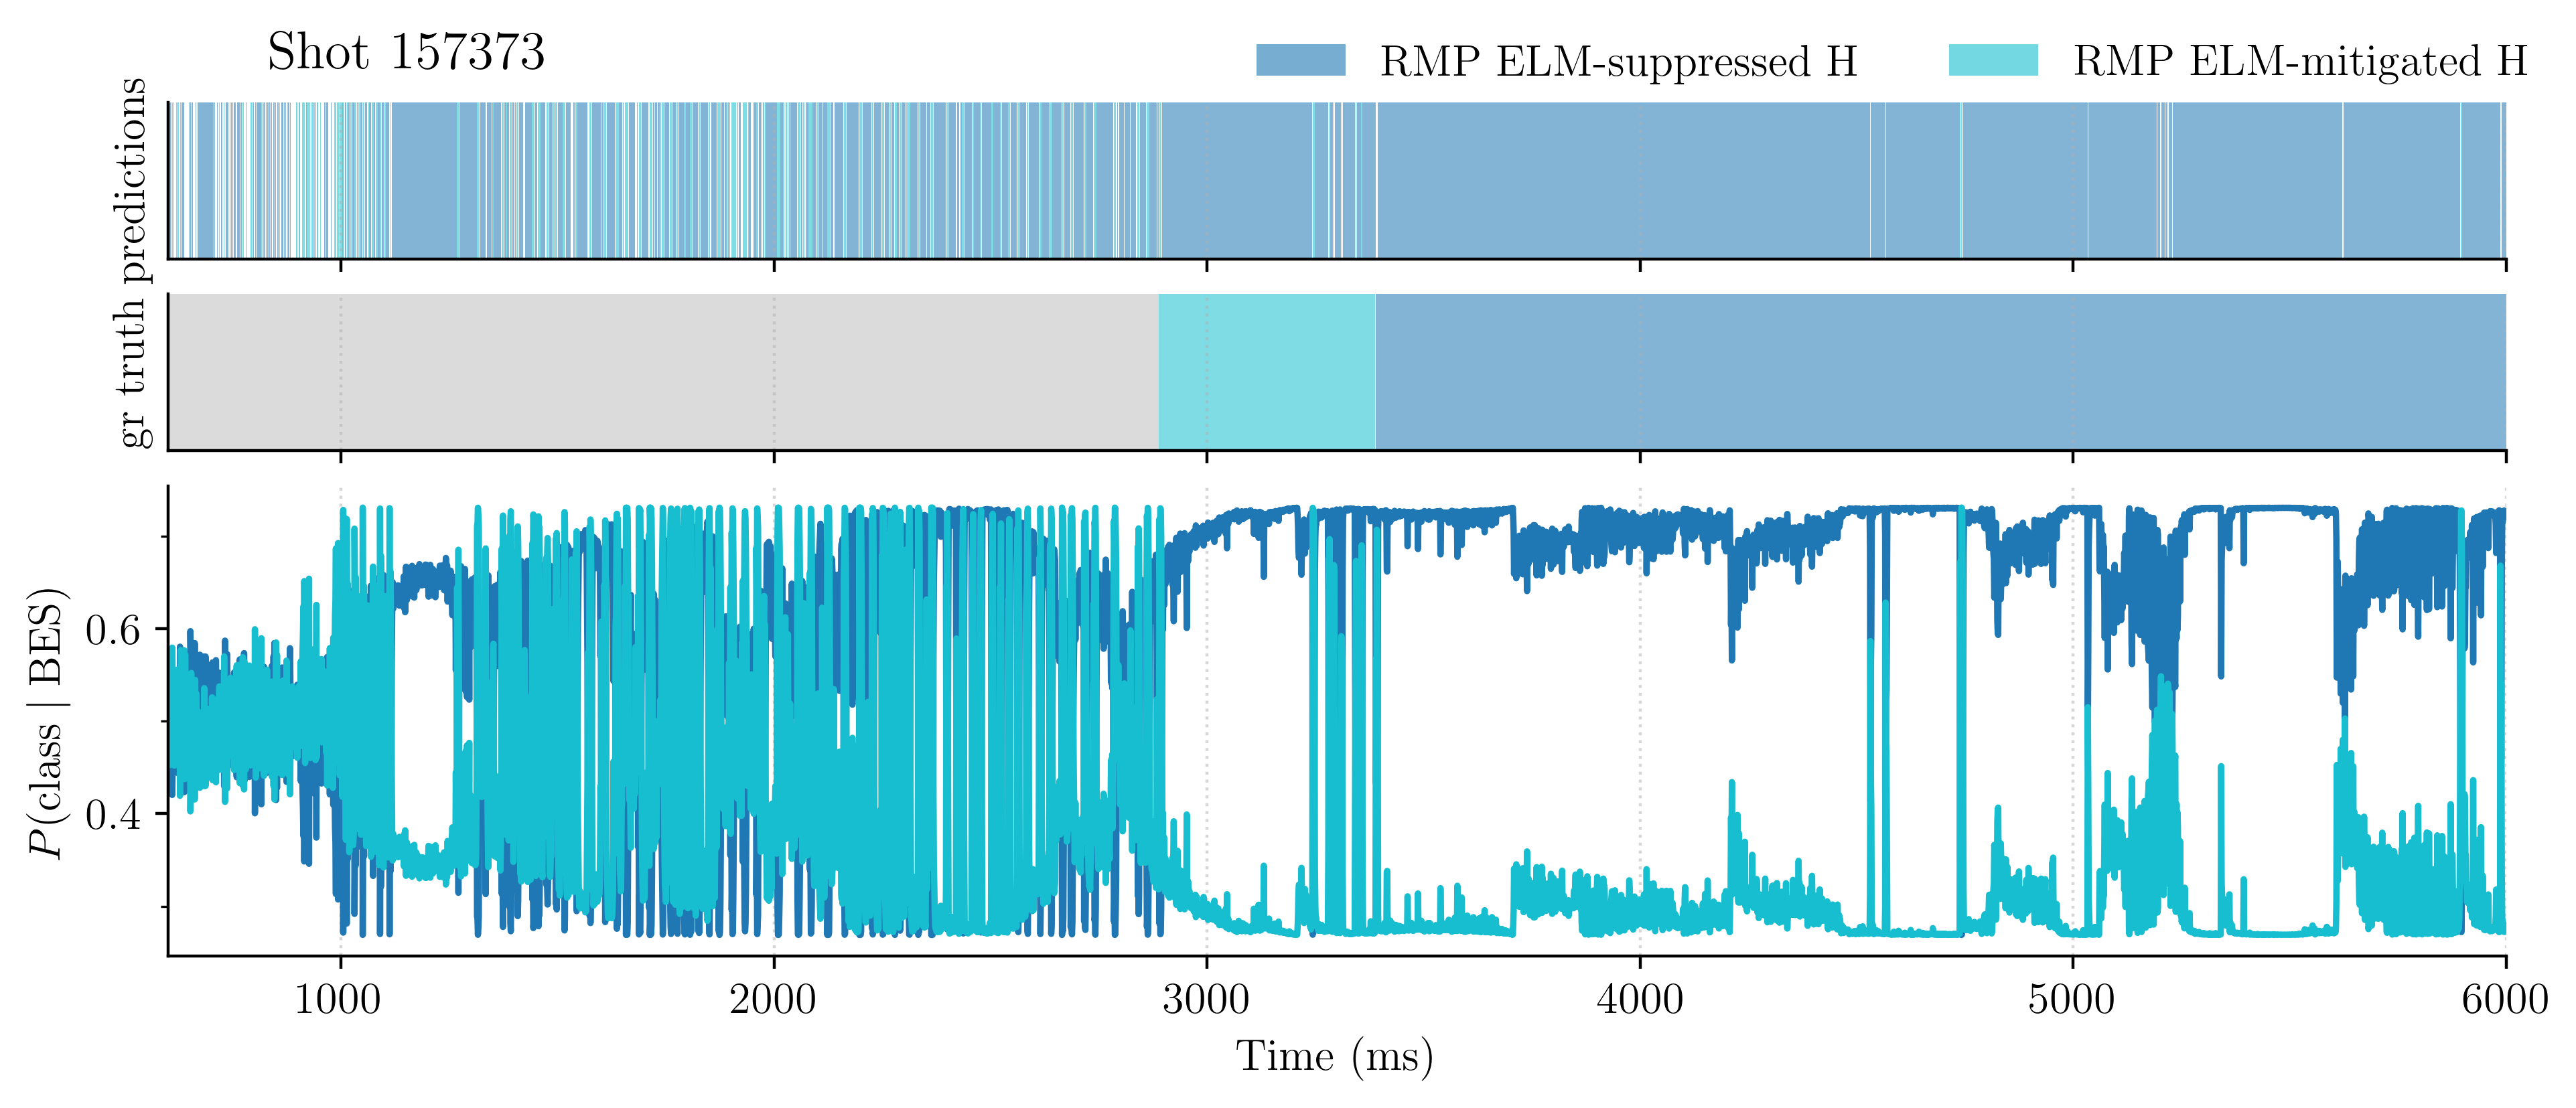

In [19]:
plot_shot(
    # h5_path="/pscratch/sd/k/kevinsg/bes_ml_jobs/exp_gill01/42683233/predictions_3.hdf5",
    # h5_path="/pscratch/sd/k/kevinsg/bes_ml_jobs/exp_gill01/42683275/predictions_3.hdf5",
    h5_path="/pscratch/sd/k/kevinsg/bes_ml_jobs/exp_gill01/42739451/predictions_1.hdf5",
    # h5_path="/pscratch/sd/k/kevinsg/bes_ml_jobs/exp_gill01/42687528/predictions_0.hdf5",
    shot="157373",
    target_downsample_ms=5.0,
    fs_hz=250_000.0,
    # class_names=["L-mode","ELM-free H","ELMy H", "RMP ELM-suppressed H"],  # if you want names
    class_names=["RMP ELM-suppressed H", "RMP ELM-mitigated H"],  # if you want names
    # save_path="shot145385_preds_vs_truth.png",
    show=True,  # headless server
)